The purpose of this code is to count the number of cells that overlaps with the red channel and the number of cells that don't.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import disk, binary_closing
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
import cv2
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

In [ ]:
def show_image(image):
    io.imshow(image)
    plt.show()
    
def preprocess_green_channel(green_channel):
    """Preprocess the green channel for inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    return confocal_img


def otsu_thresholding(channel):
    """Apply Otsu's thresholding and morphological closing to the channel."""
    threshold_value = threshold_otsu(channel)
    binary_image = channel > threshold_value
    # show_image(binary_image)
    closed_image = binary_closing(binary_image, disk(3))
    labeled_image = label(closed_image)
    return labeled_image



In [ ]:
def analyze_image(image_path, basename):
    """
    Analyze an image by its individual cells.
    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each image, including the number of cells that overlap with the red channel and cells that do not.
    """
    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)

    # Separate the channels
    red_channel = image_squeezed[0, :, :]
    red_channel = cv2.resize(red_channel, (1000, 1000), interpolation = cv2.INTER_LINEAR) # resize to 1000x1000
    green_channel = image_squeezed[1, :, :]
    green_channel = cv2.resize(green_channel, (1000, 1000), interpolation = cv2.INTER_LINEAR) # resize to 1000x1000

    green_channel = preprocess_green_channel(green_channel)
    print("Green Channel")
    show_image(green_channel)

    # Segment cells in the green channel
    green_channel_remove_inclusions = np.where(green_channel < 0.8, green_channel, 0) # remove inclusions
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=10) # blur
    # Detect cells in the green channel
    masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=100, channels=[0, 0])
    labeled_cells = label(masks)
    
    print("Segmented Cells")
    show_image(labeled_cells)

    # Threshold the red channel
    red_channel_thresholded = otsu_thresholding(red_channel)
    print("Red Channel Thresholded")
    show_image(red_channel_thresholded)


    # Initialize lists to store results
    cells_with_red = []
    cells_without_red = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        mask = labeled_cells == cell.label
        applied_mask = mask * green_channel

        overlap = applied_mask * red_channel_thresholded
        if overlap.sum() > 0:
            cells_with_red.append(i)
        else:
            cells_without_red.append(i)

    # Create a DataFrame with the results
    df1 = pd.DataFrame({
        "File_Name:": [basename],
        "Cells_With_Red": [len(cells_with_red)],
        "Cells_Without_Red": [len(cells_without_red)],
        "Total_Cells": [len(cells_with_red) + len(cells_without_red)],
    })
    
    return df1


In [ ]:
def analyze_all_images(image_folder):
    all_data_1 = []
    for image in os.listdir(image_folder):
        
        if image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(image)

            image_path = os.path.join(image_folder, image)
            image_base_name = os.path.basename(image)[:-4]
            
            df1 = analyze_image(image_path, image_base_name)
            all_data_1.append(df1)
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder.split('/')[0][-6:]}_analysis_by_image.xlsx", index=False)


Define Main Function

In [ ]:
folders = ['PI_Hoechst_spermine_102924']


Spermine_1000_PI_Hoechst_01.czi
Green Channel


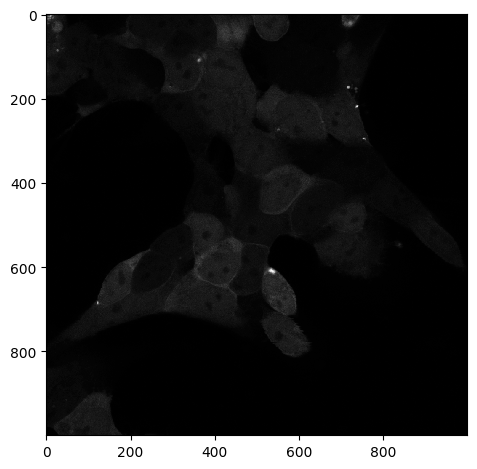

Segmented Cells


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


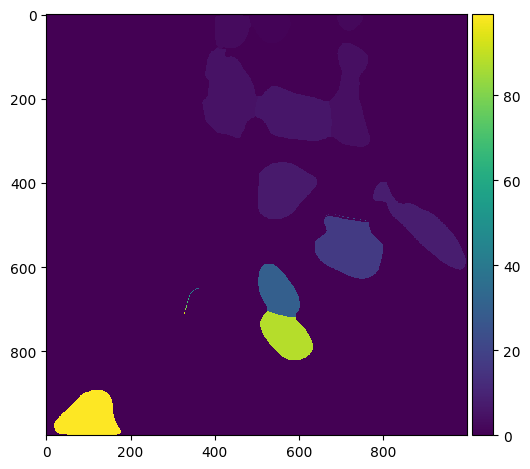

Red Channel Thresholded


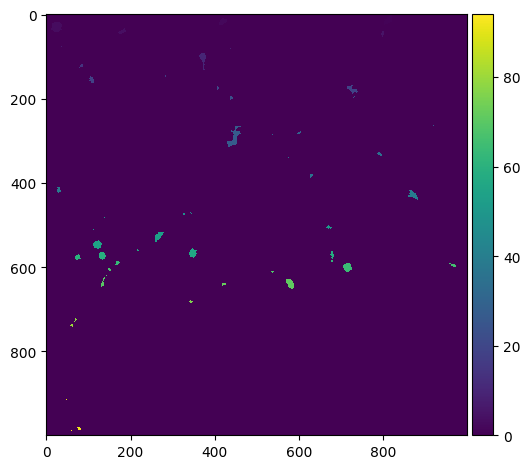

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_1000_PI_Hoechst_02.czi
Green Channel


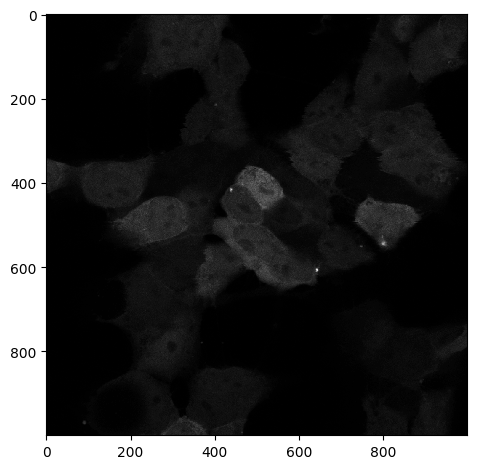

Segmented Cells


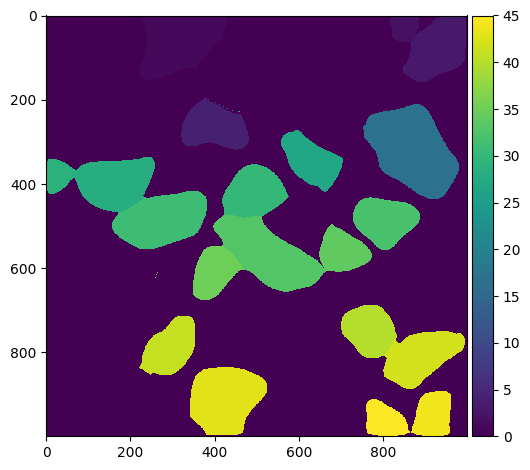

Red Channel Thresholded


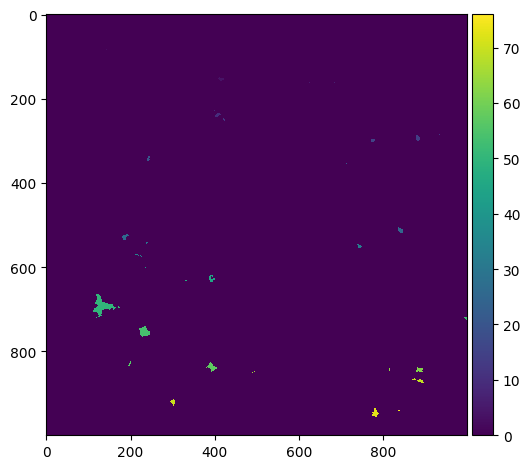

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_1000_PI_Hoechst_03.czi
Green Channel


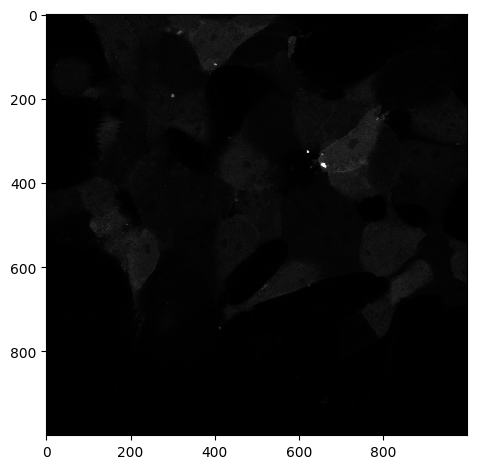

Segmented Cells


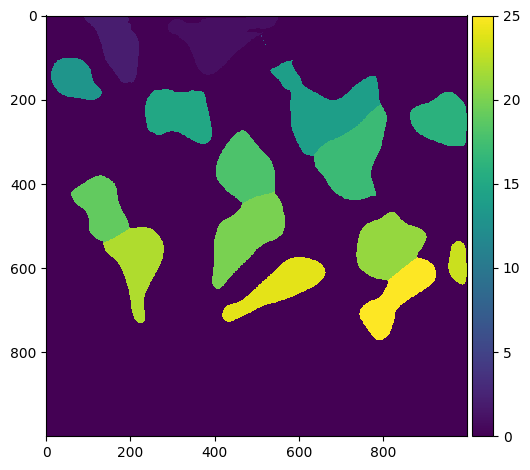

Red Channel Thresholded


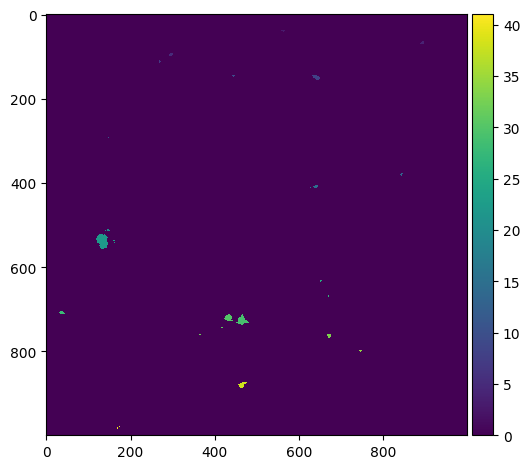

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_1000_PI_Hoechst_04.czi
Green Channel


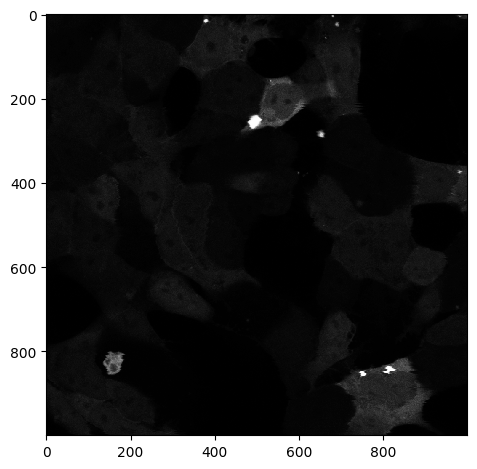

Segmented Cells


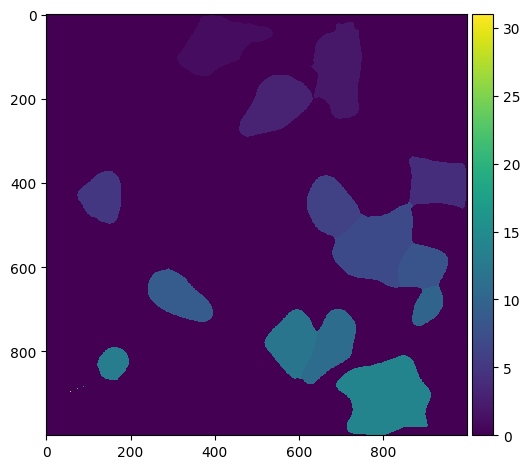

Red Channel Thresholded


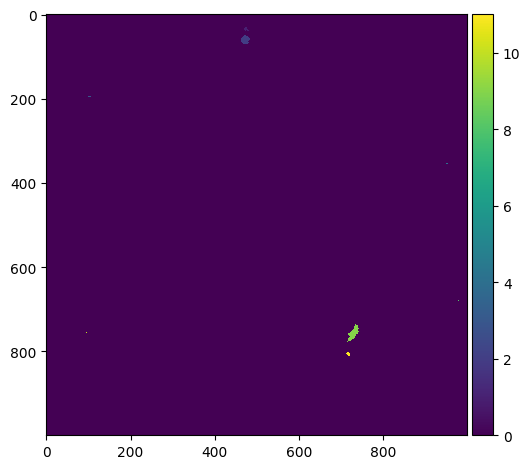

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_16000_PI_Hoechst_01.czi
Green Channel


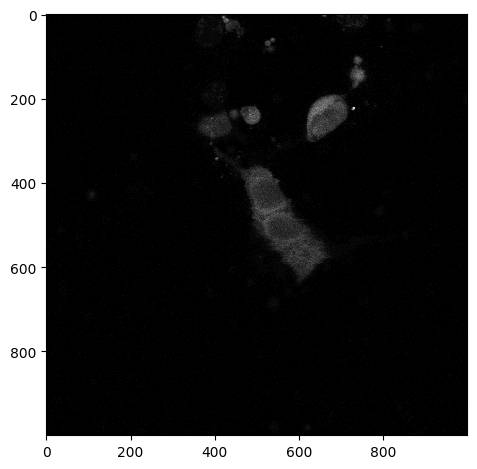

Segmented Cells


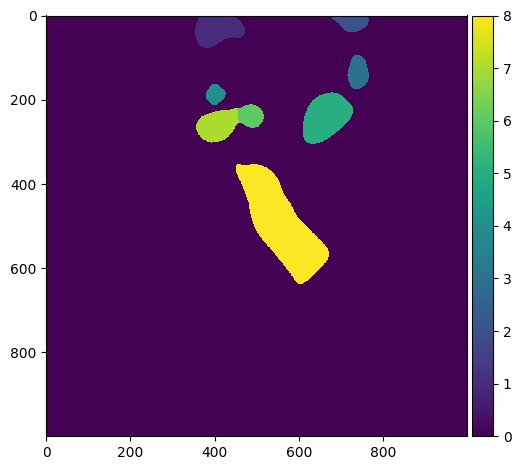

Red Channel Thresholded


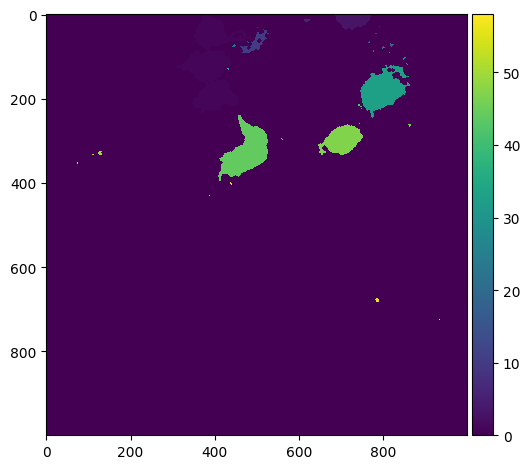

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_16000_PI_Hoechst_02.czi
Green Channel


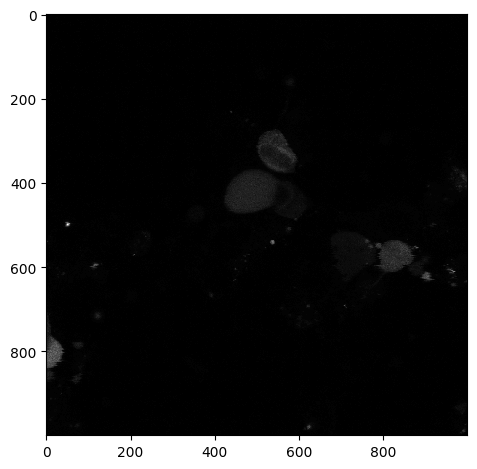

Segmented Cells


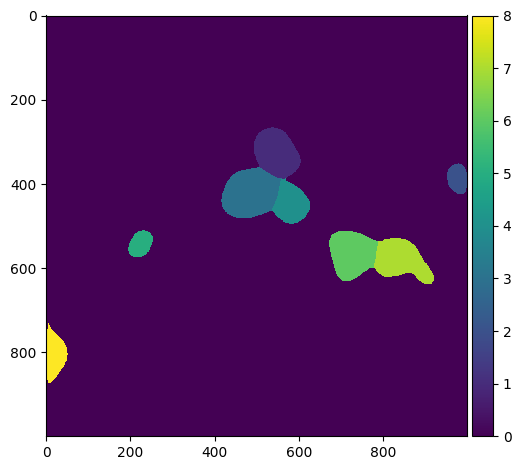

Red Channel Thresholded


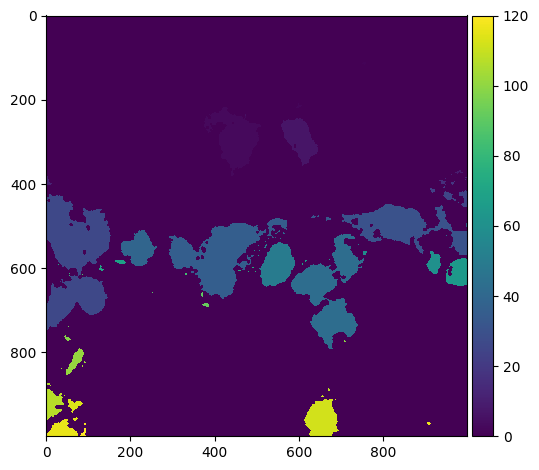

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_16000_PI_Hoechst_03.czi
Green Channel


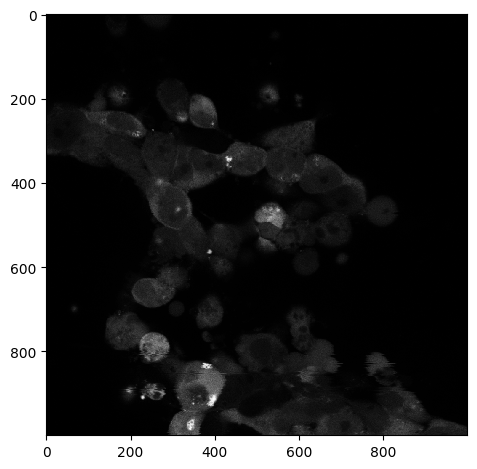

Segmented Cells


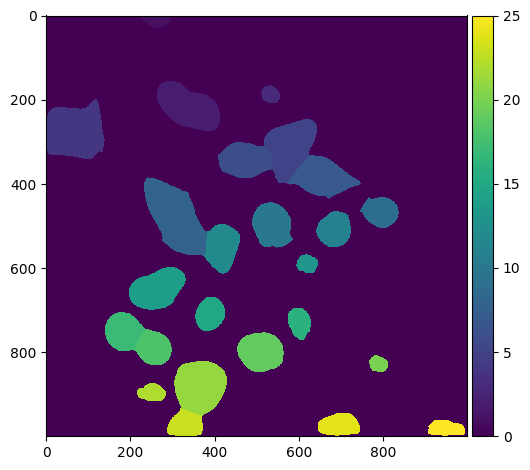

Red Channel Thresholded


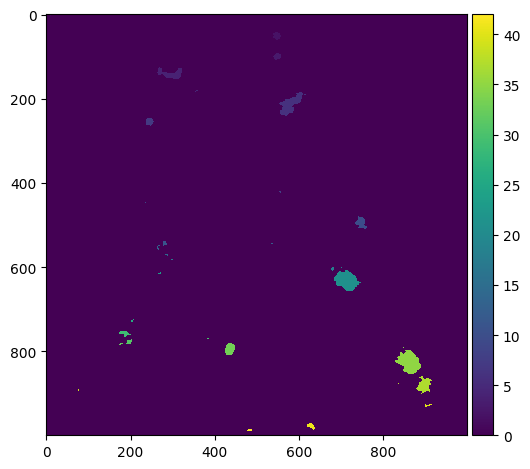

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_16000_PI_Hoechst_04.czi
Green Channel


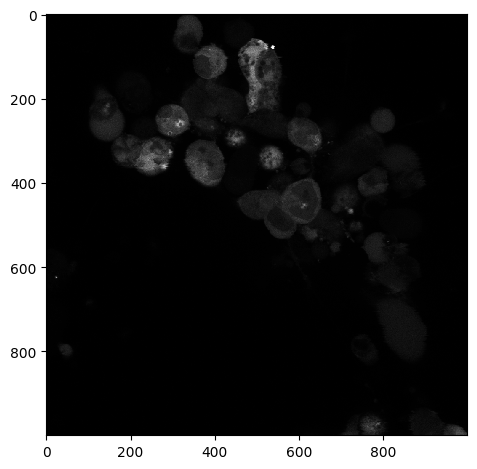

Segmented Cells


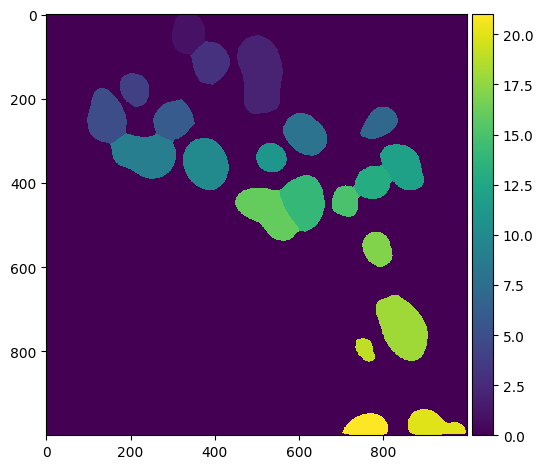

Red Channel Thresholded


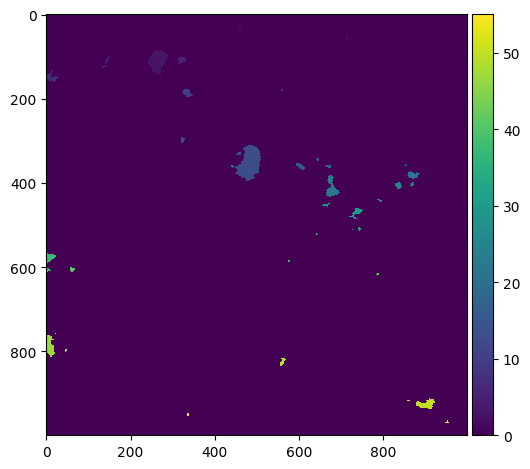

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_2000_PI_Hoechst_01.czi
Green Channel


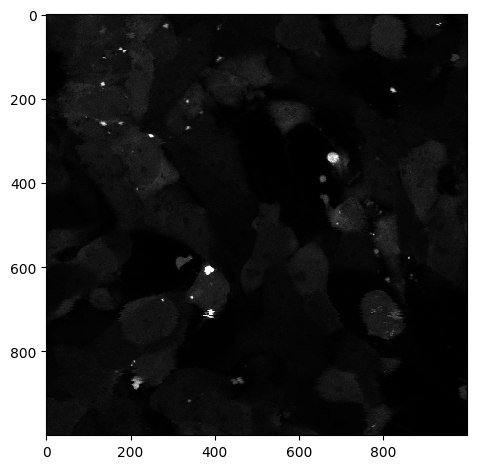

Segmented Cells


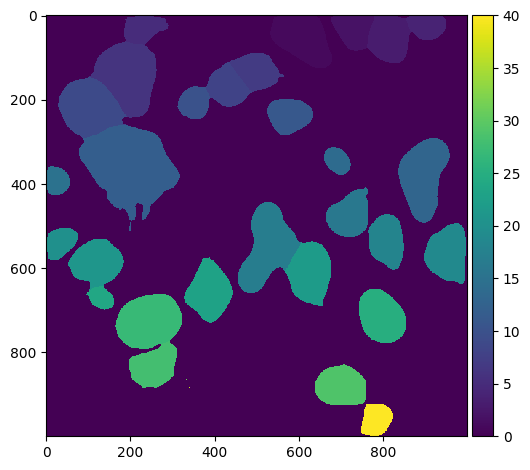

Red Channel Thresholded


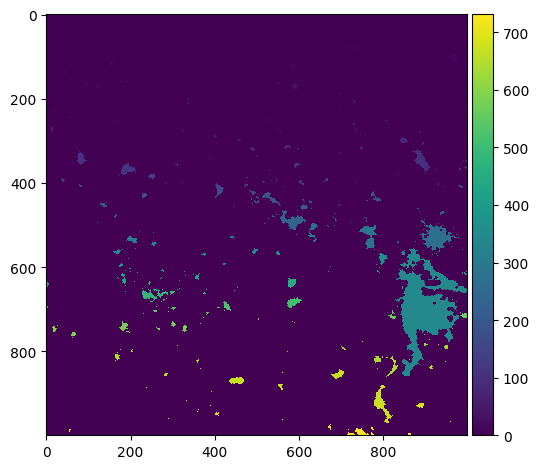

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_2000_PI_Hoechst_02.czi
Green Channel


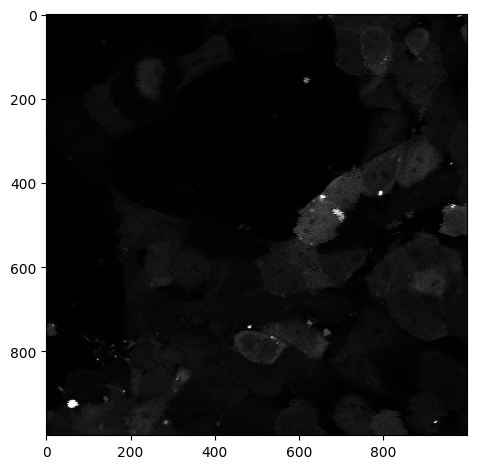

Segmented Cells


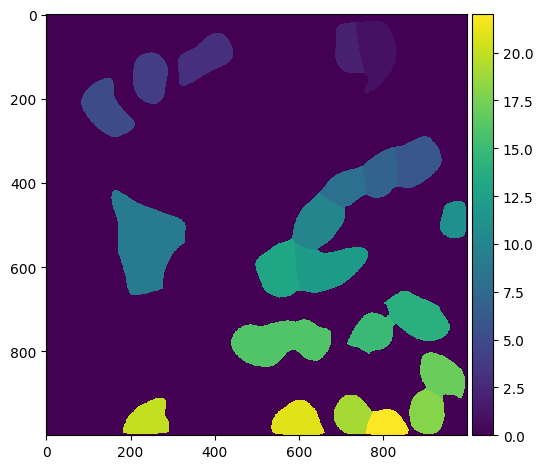

Red Channel Thresholded


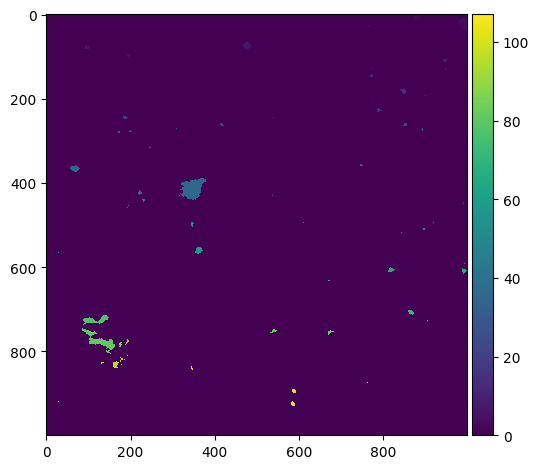

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_2000_PI_Hoechst_03.czi
Green Channel


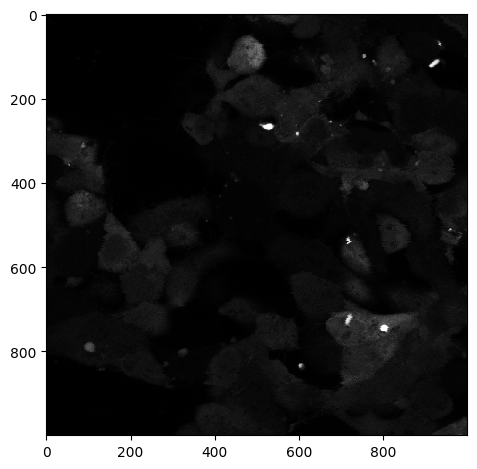

Segmented Cells


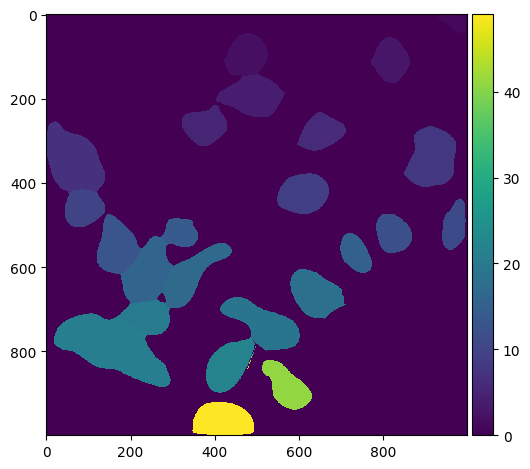

Red Channel Thresholded


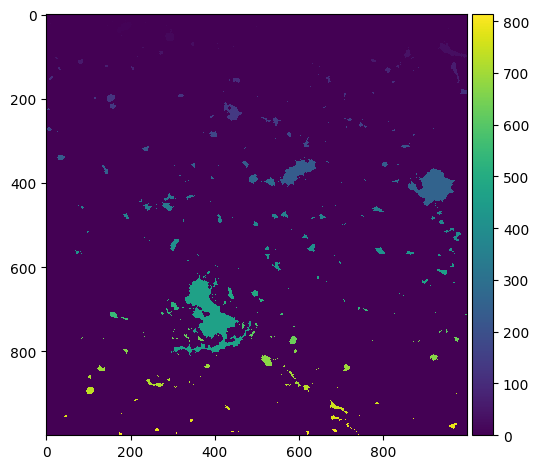

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_2000_PI_Hoechst_04.czi
Green Channel


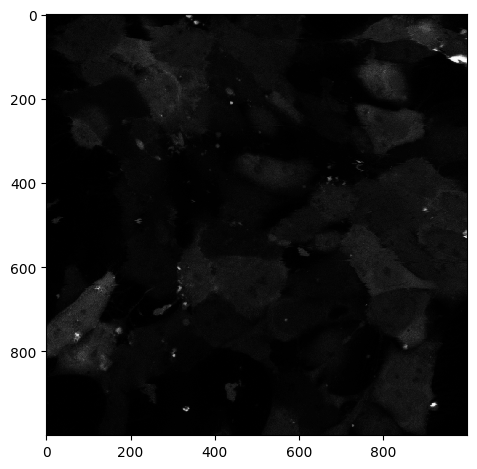

Segmented Cells


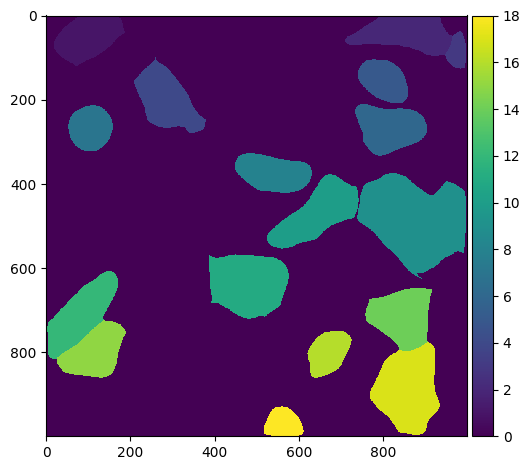

Red Channel Thresholded


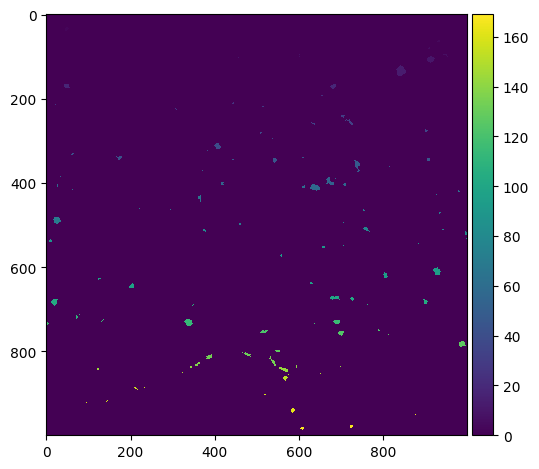

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_250_PI_Hoechst_01.czi
Green Channel


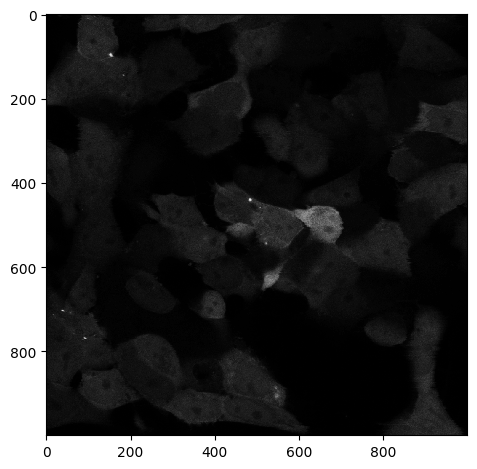

Segmented Cells


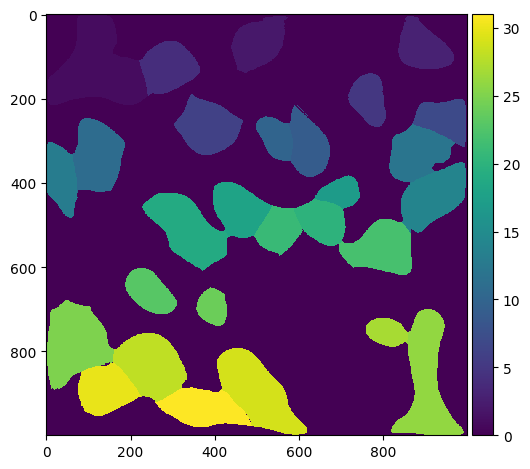

Red Channel Thresholded


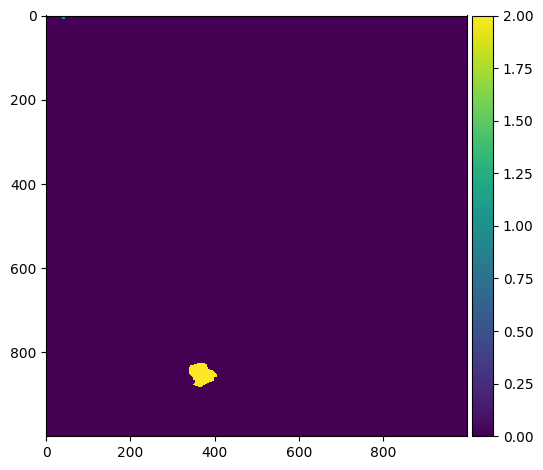

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_250_PI_Hoechst_02.czi
Green Channel


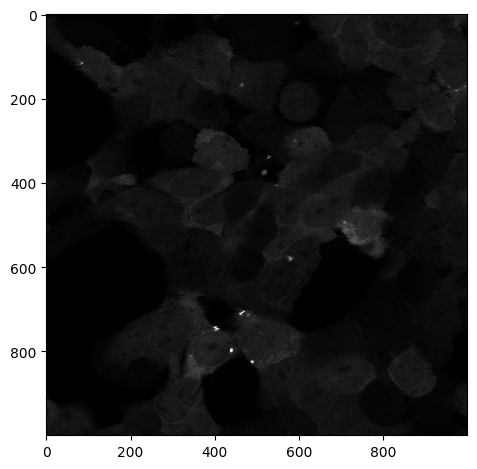

Segmented Cells


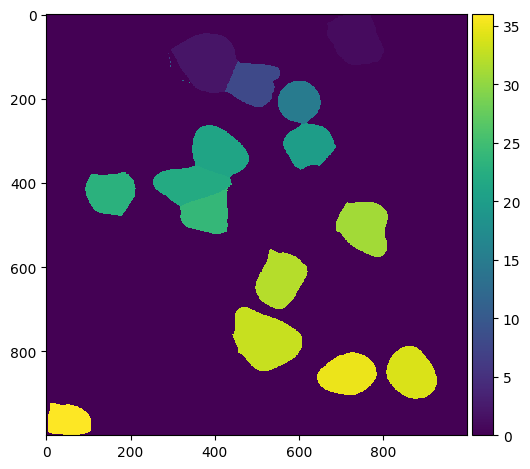

Red Channel Thresholded


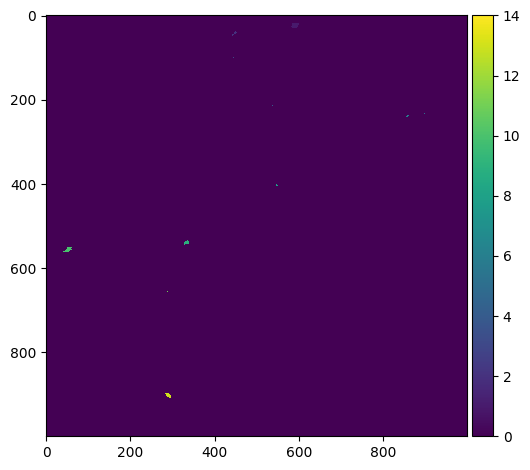

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_250_PI_Hoechst_03.czi
Green Channel


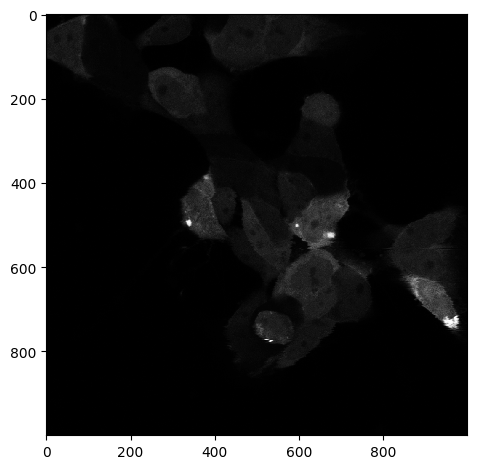

Segmented Cells


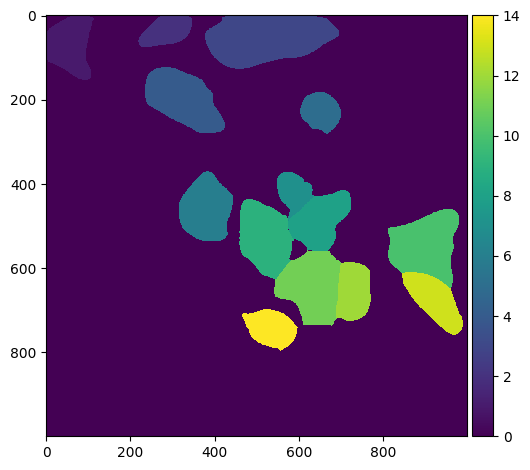

Red Channel Thresholded


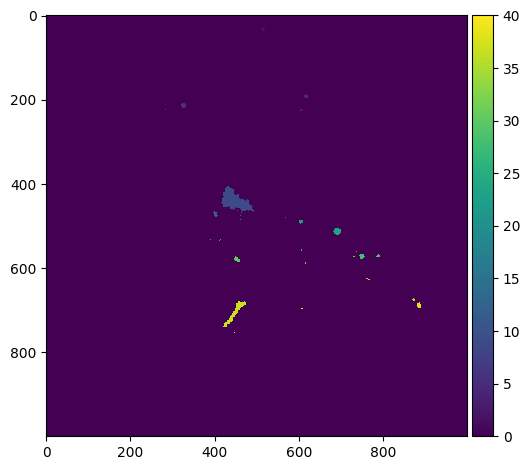

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_250_PI_Hoechst_04.czi
Green Channel


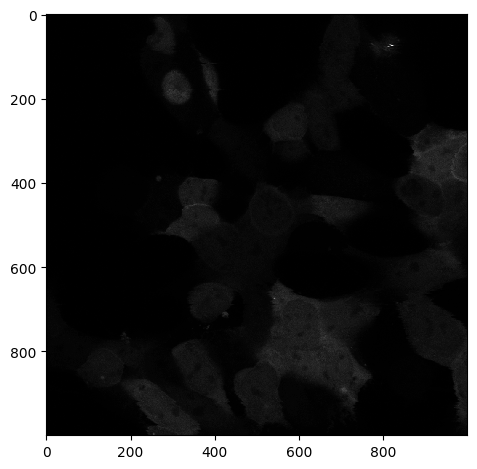

Segmented Cells


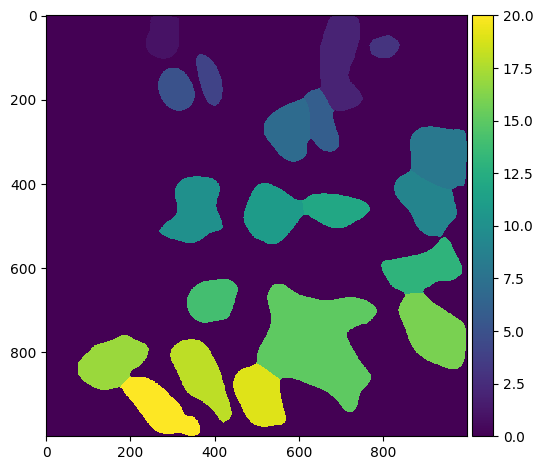

Red Channel Thresholded


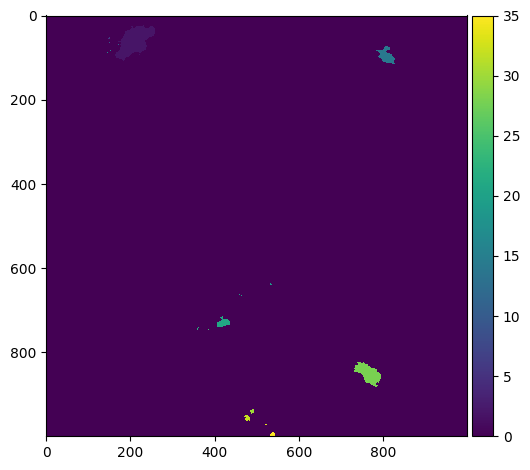

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_4000_PI_Hoechst_01.czi
Green Channel


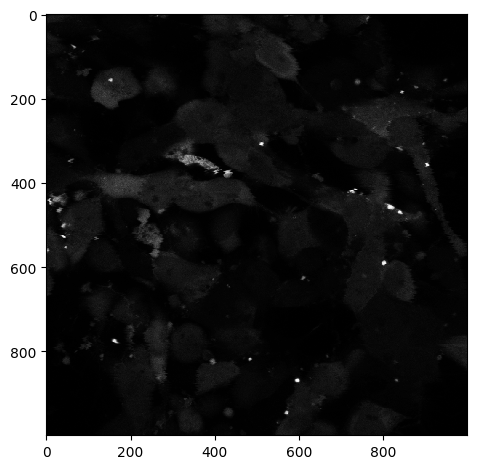

Segmented Cells


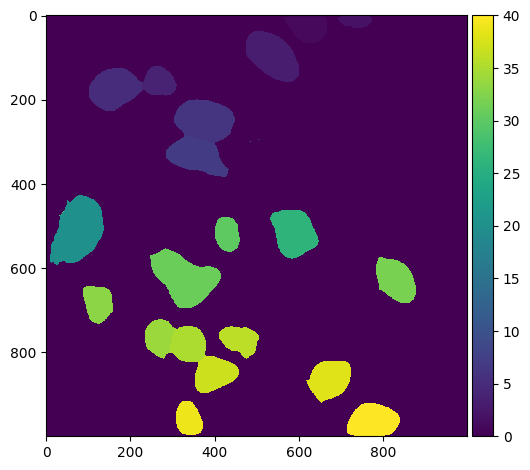

Red Channel Thresholded


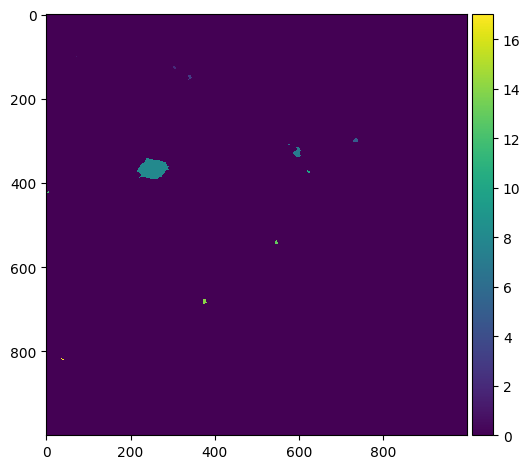

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_4000_PI_Hoechst_02.czi
Green Channel


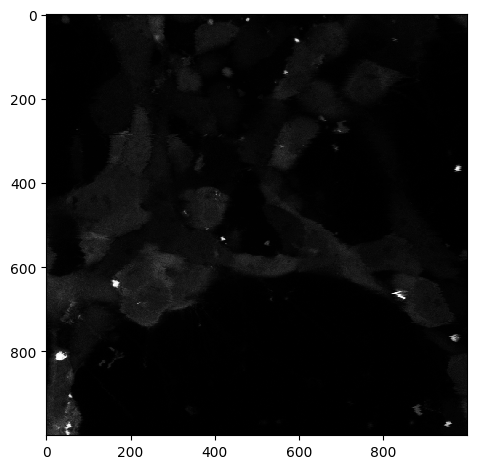

Segmented Cells


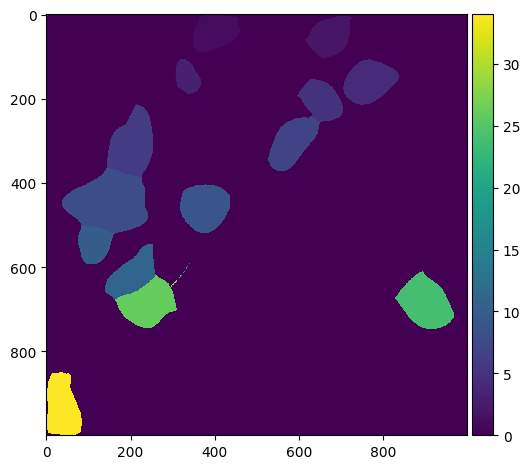

Red Channel Thresholded


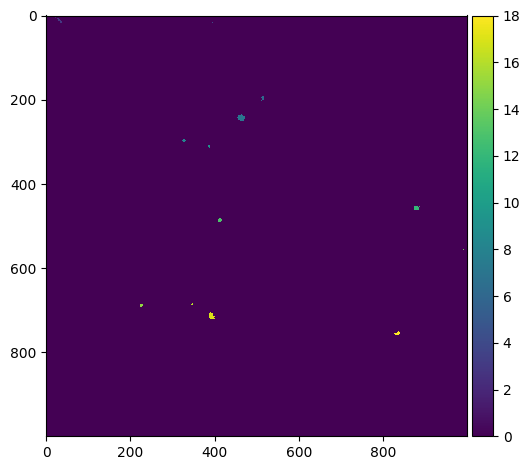

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_4000_PI_Hoechst_03.czi
Green Channel


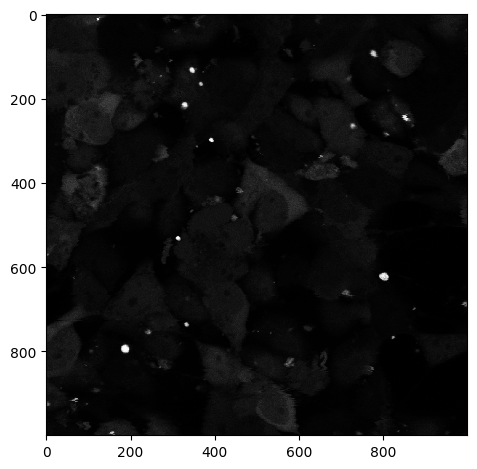

Segmented Cells


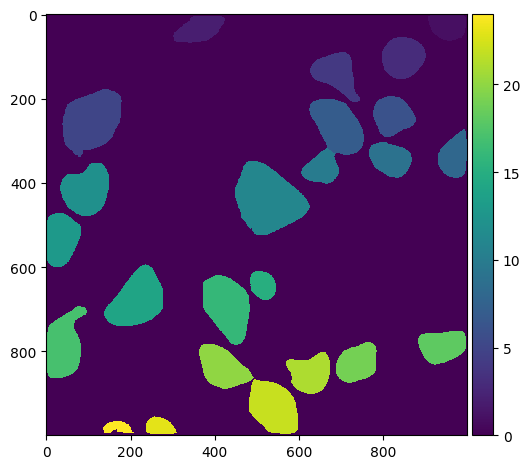

Red Channel Thresholded


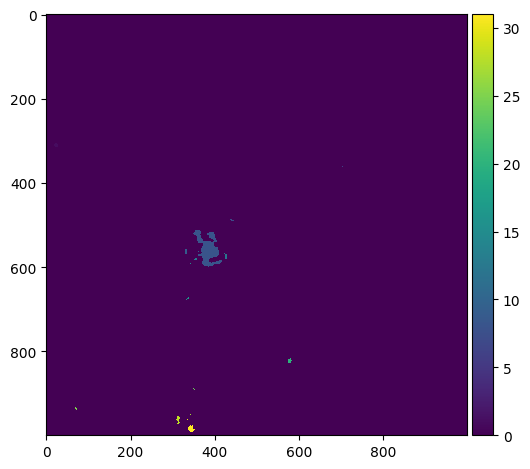

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_4000_PI_Hoechst_04.czi
Green Channel


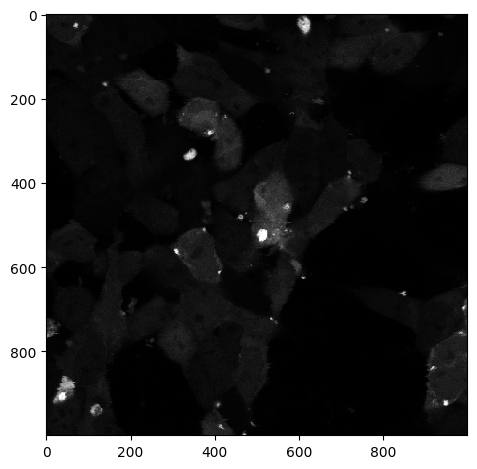

Segmented Cells


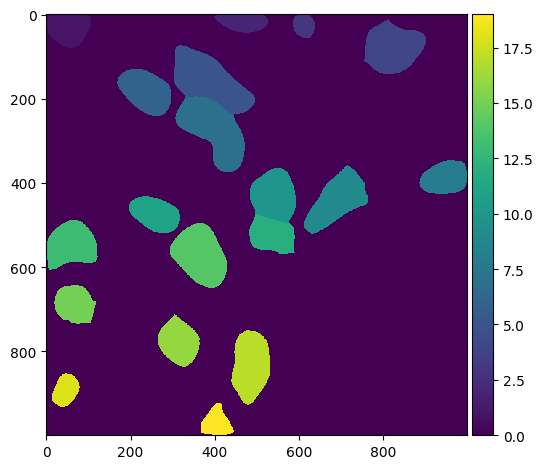

Red Channel Thresholded


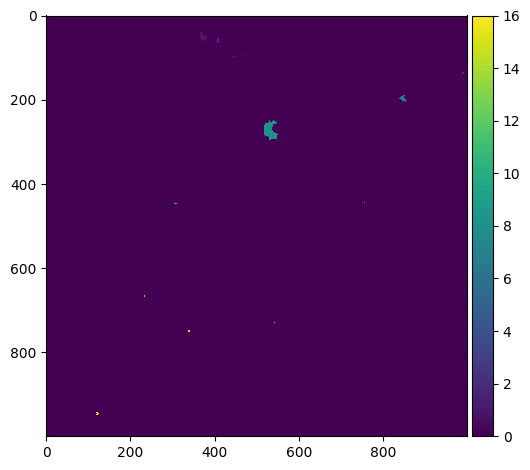

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_500_PI_Hoechst_01.czi
Green Channel


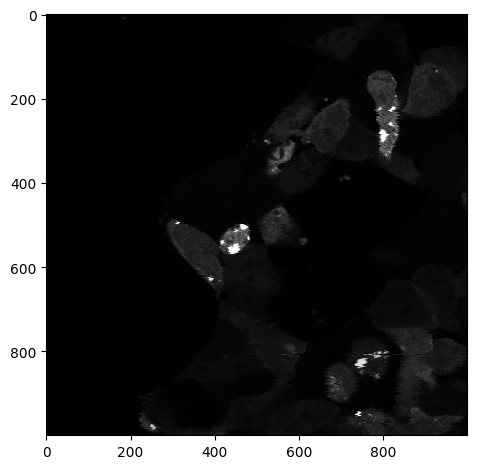

Segmented Cells


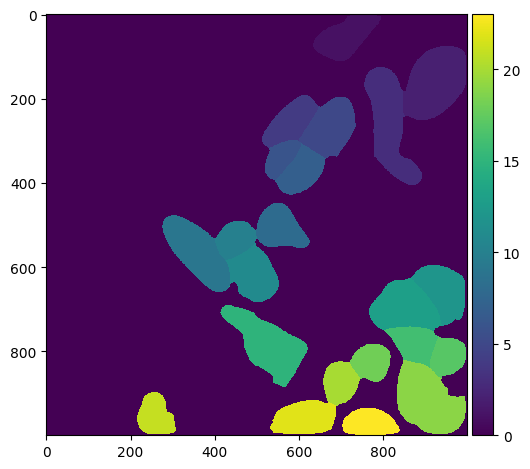

Red Channel Thresholded


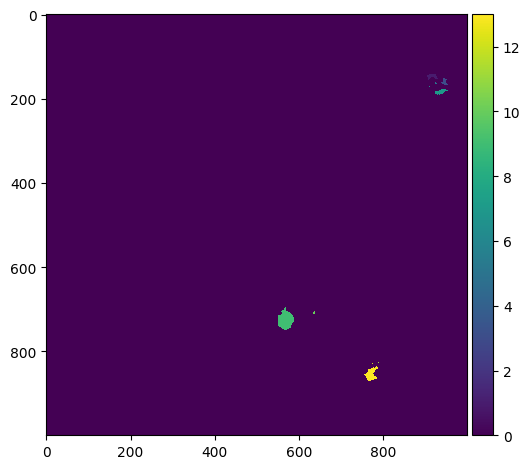

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_500_PI_Hoechst_02.czi
Green Channel


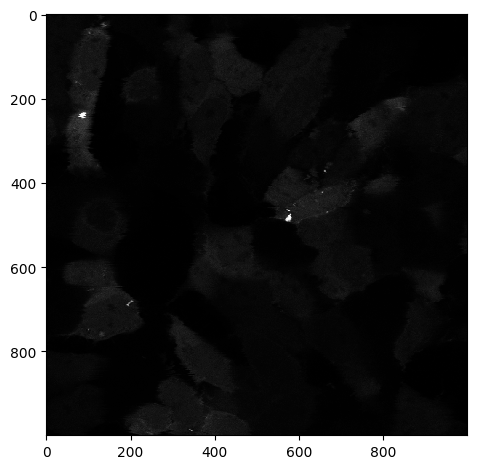

Segmented Cells


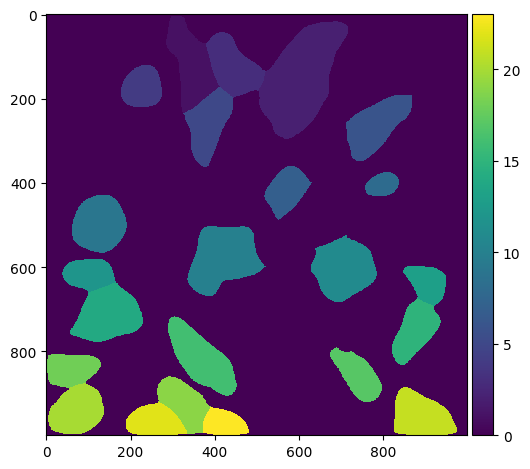

Red Channel Thresholded


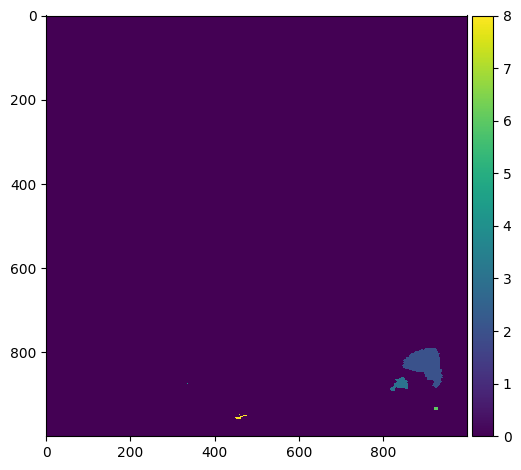

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_500_PI_Hoechst_03.czi
Green Channel


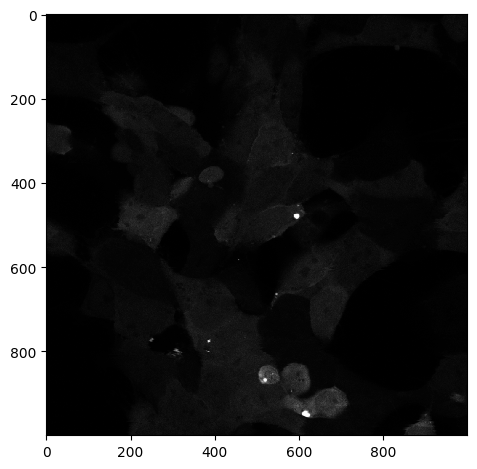

Segmented Cells


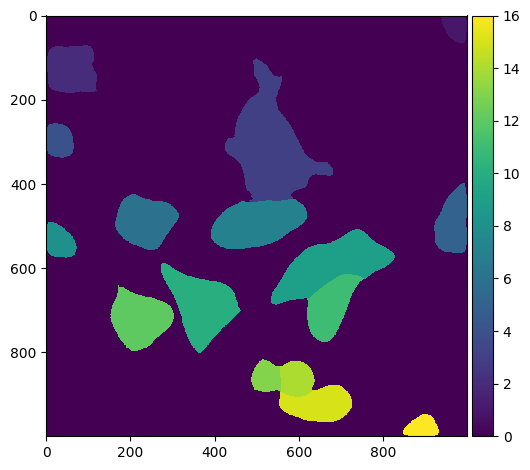

Red Channel Thresholded


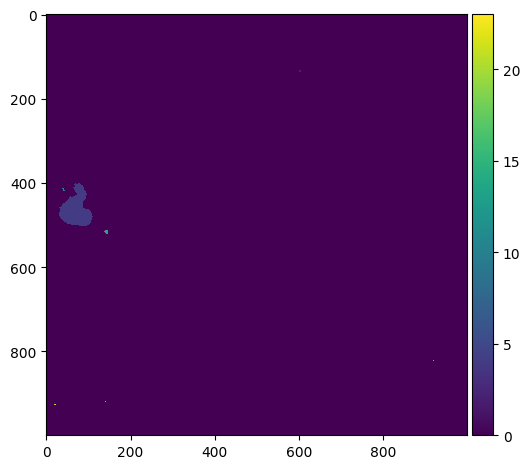

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_500_PI_Hoechst_04.czi
Green Channel


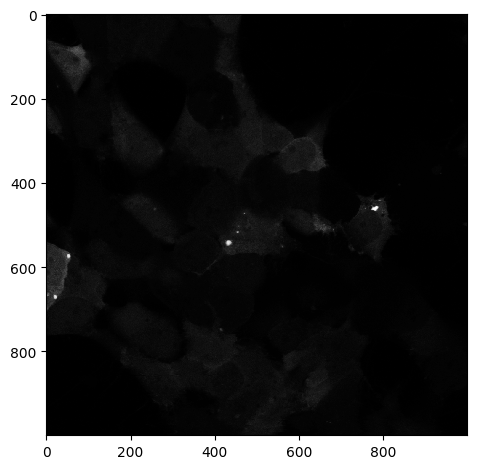

Segmented Cells


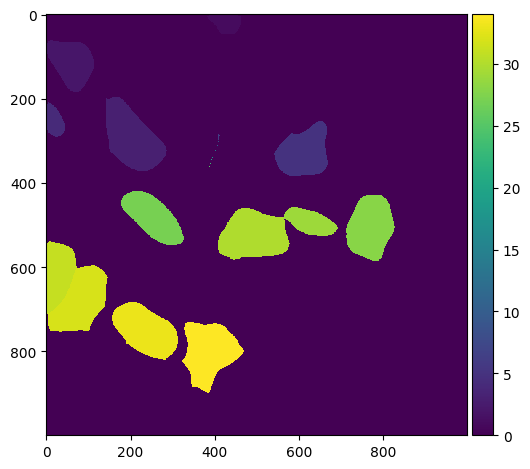

Red Channel Thresholded


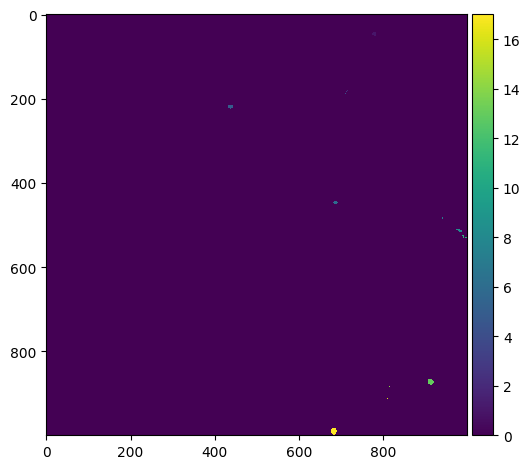

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_8000_PI_Hoechst_01.czi
Green Channel


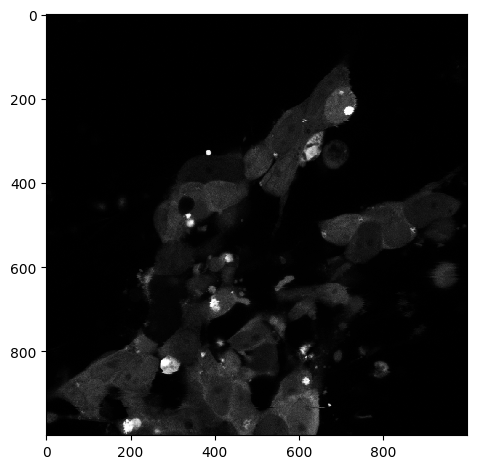

Segmented Cells


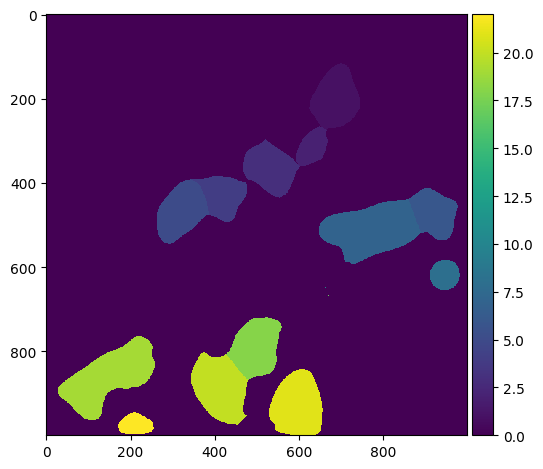

Red Channel Thresholded


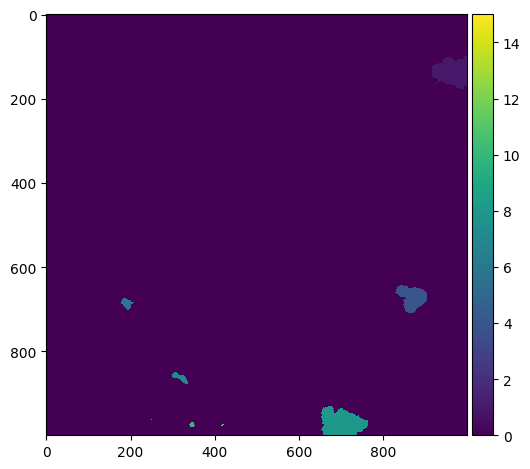

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_8000_PI_Hoechst_02.czi
Green Channel


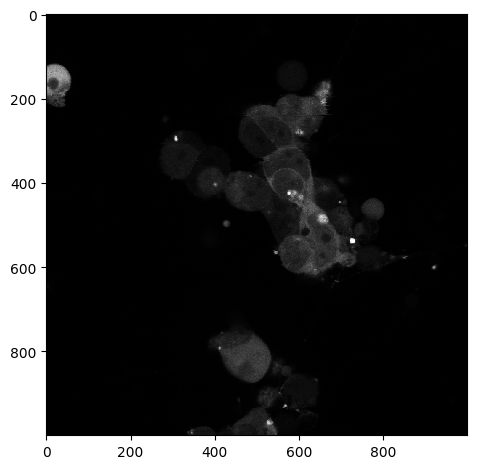

Segmented Cells


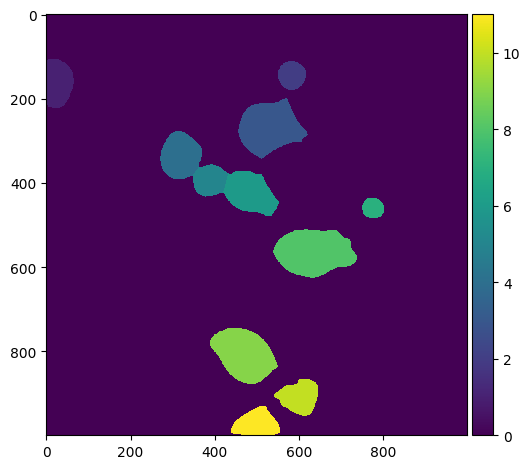

Red Channel Thresholded


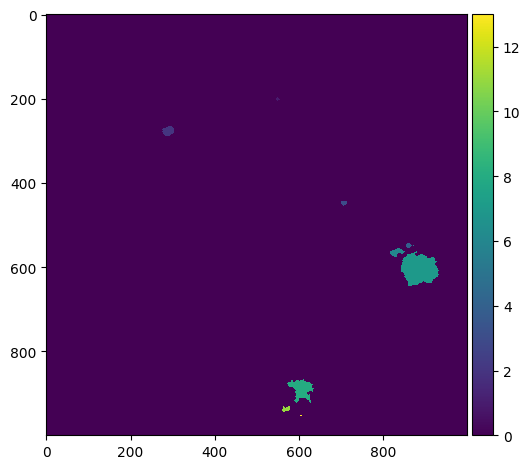

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_8000_PI_Hoechst_03.czi
Green Channel


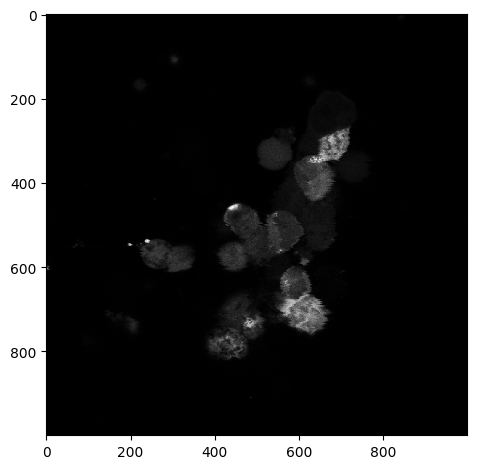

Segmented Cells


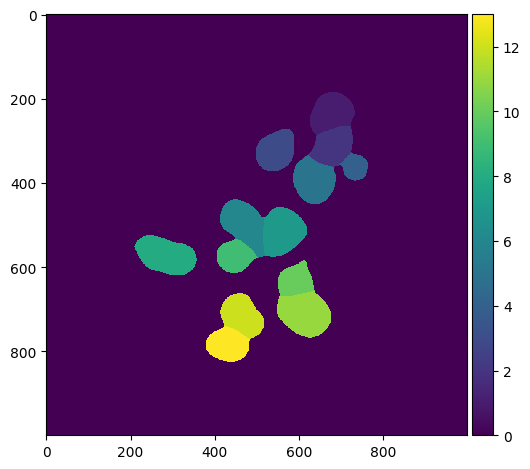

Red Channel Thresholded


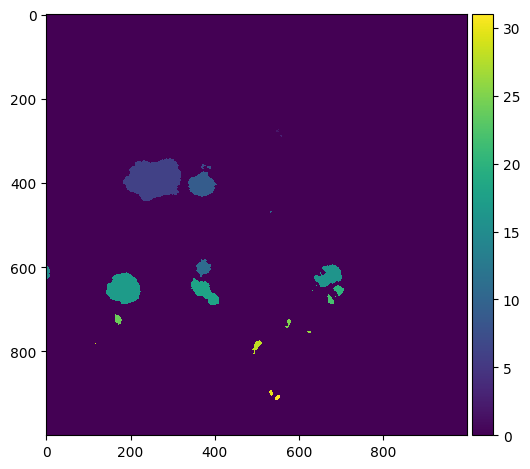

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Spermine_8000_PI_Hoechst_04.czi
Green Channel


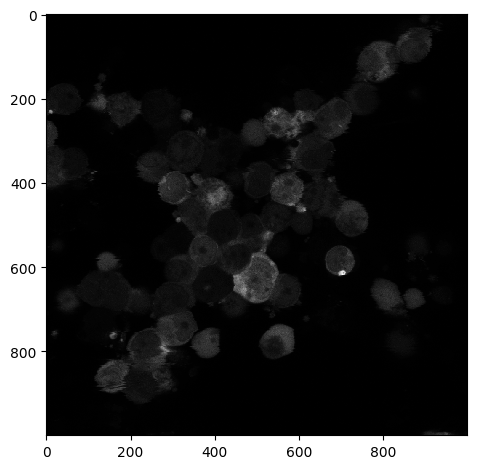

Segmented Cells


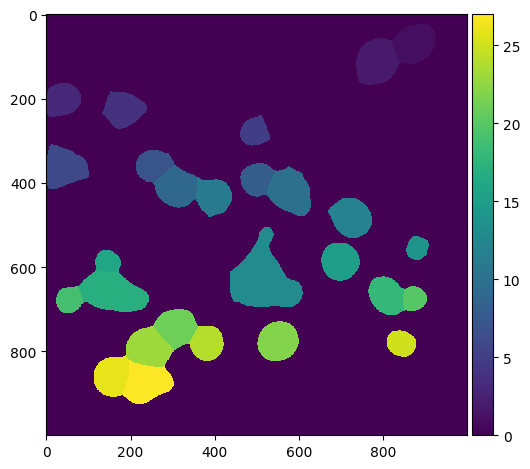

Red Channel Thresholded


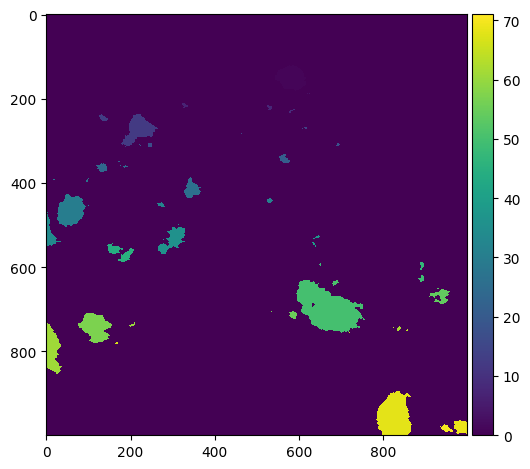

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
UT_PI_Hoechst_01.czi
Green Channel


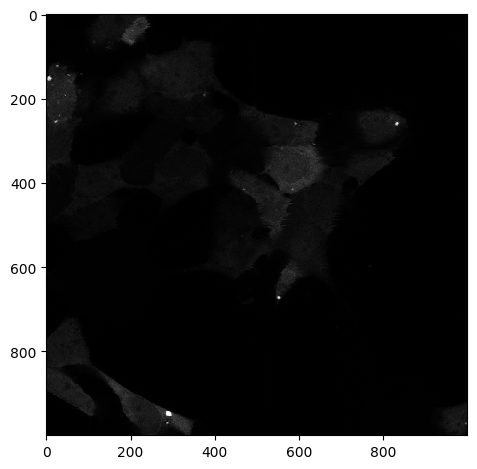

Segmented Cells


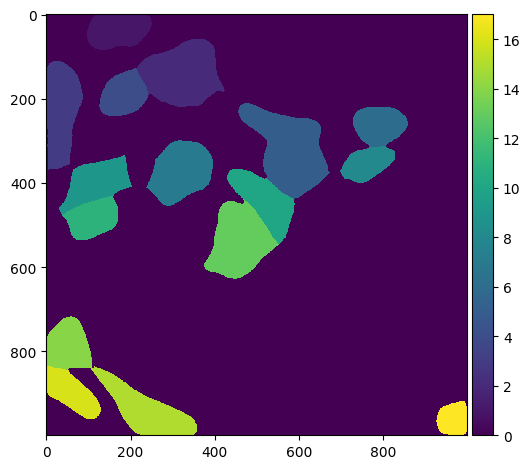

Red Channel Thresholded


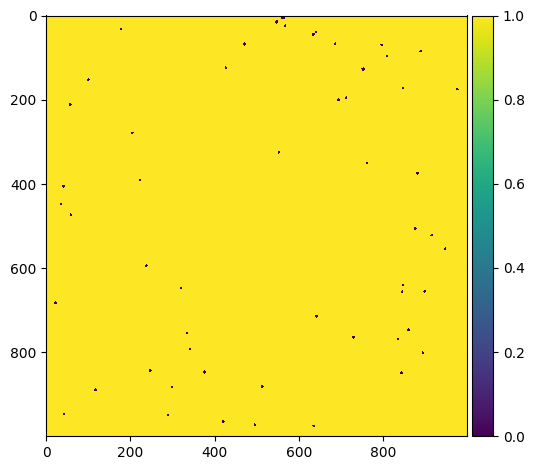

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
UT_PI_Hoechst_02.czi
Green Channel


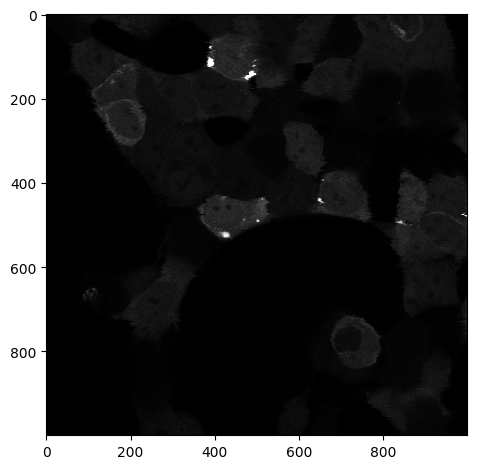

Segmented Cells


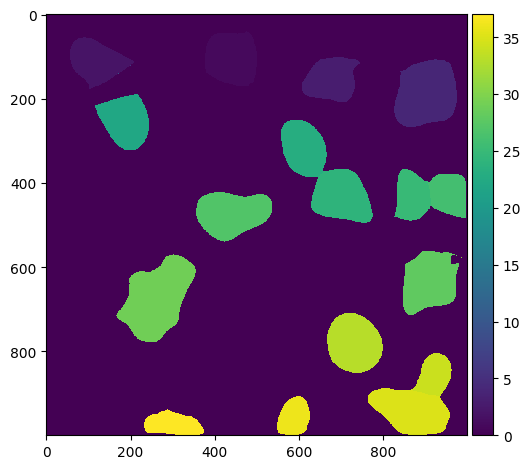

Red Channel Thresholded


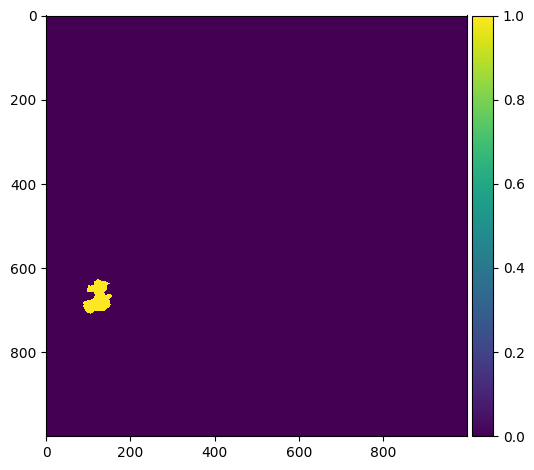

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
UT_PI_Hoechst_03.czi
Green Channel


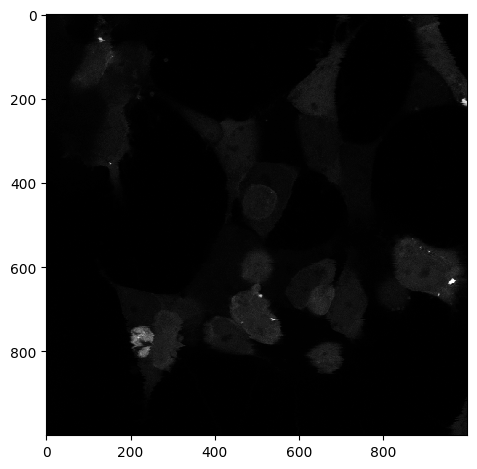

Segmented Cells


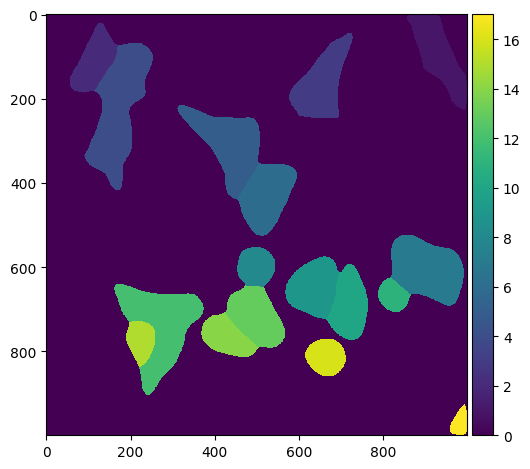

Red Channel Thresholded


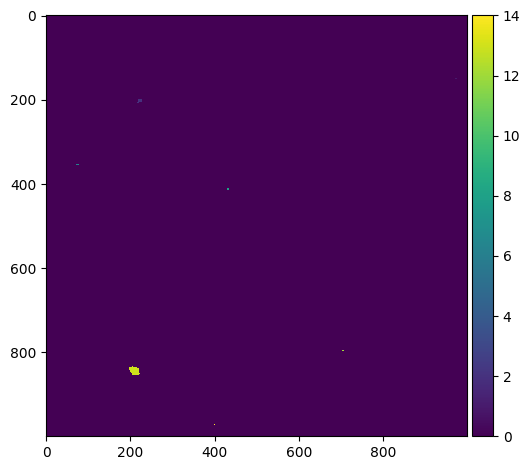

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
UT_PI_Hoechst_04.czi
Green Channel


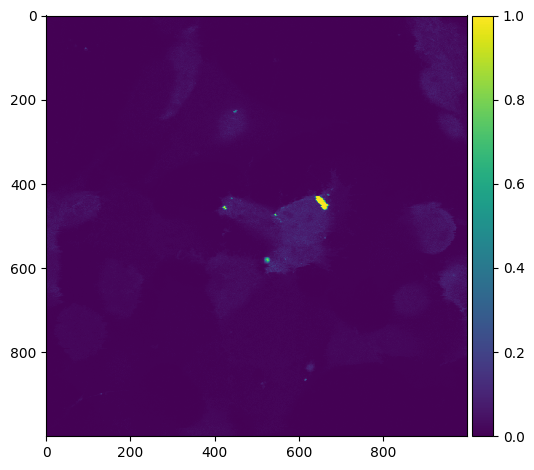

Segmented Cells


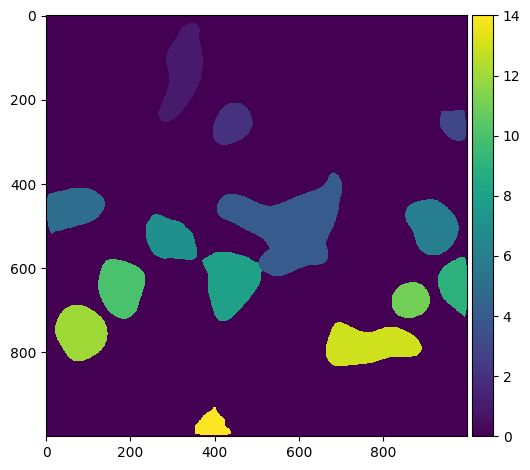

Red Channel Thresholded


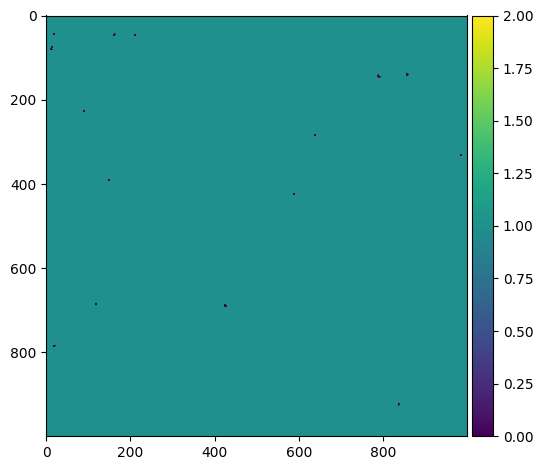

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:

analyze_all_images(folders[0])
